# Formation RNAseq CEA - juin 2023

*Enseignantes: Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 8: Exploratory analysis I (before normalisation)

   

- 0. 1 - Setting up this R session on IFB core cluster
- 0. 2 - Parameters to be set or modified by the user
- 1 - Loading input data and metadata
- 2 - Quality assessment
- 3 - Saving our results

---
## **Before going further**

<div class="alert alert-block alert-danger"><b>Caution:</b> 
Before starting the analysis, save a backup copy of this notebok : in the left-hand panel, right-click on this file and select "Duplicate"<br>
You can also make backups during the analysis. Don't forget to save your notebook regularly: <kbd>Ctrl</kbd> + <kbd>S</kbd> or click on the 💾 icon.
</div>

<div class="alert alert-block alert-warning"><b>Warning:</b>You are strongly advised to run the cells in the indicated order. If you want to rerun cells above, you can just restart the kernel to start at 1 again. </div>

---
---
## 0. Set up parameters and RSession

---

### 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

#### **0.1-a. Jupyer session**

Just as in a bash notebook, we can have information about the number of threads available for this session. To do so, we will use the `system()`function in R which executes bash commands.

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Mon Jun  5 01:24:19 CEST 2023 ==="                        
[2] "          33651711      fast  jupyter cvandied  R    1:51:52      1 cpu-node-7"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                        
[4] "       JobID  AllocCPUS        NodeList "                                      
[5] "------------ ---------- --------------- "                                      
[6] "33651711              5      cpu-node-7 "                                      


__

#### **0.1-b. R session**

Next we load into this R session the various packages that we will use.


<div class="alert alert-block alert-info"> <b> Info on packages: </b><br>
    
Since this is the first time during this course we are using R packages, the next code cells 2-5 will explain you some basic commands to deal with R packages. </div>

In R we can call packages with some functions to do special analyses.
To call such a package, the usual command is `library(name_of_the_package)`. It works if the package is already installed on your computer/server, otherwise you have to install it from the main R repository called CRAN (https://cran.r-project.org/). The main function to install R packages is `install.packages()`. Some packages are not available via the CRAN package repository, specifically the ones used in bioinformatic analyses, but via ***Bioconductor***. In order to install a package from Bioconductor, you need to install the `BiocManager` package first, then use its fonction install(). An example of the commands to use is provided in cell code 5.

- We can first identify the directories, called ***libraries***, where these packages are installed. 

In [2]:
## Code cell 2 ##

.libPaths()

[1] "/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0"
[2] "/shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/R/library"

If this is the first time you are using R on the IFB core cluster or you never installed packages before, the previous command should return only one folder, readable by all IFB users. It should be : `/shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/R/library`.

If you have already installed R packages, you should see another folder in your home directory, most likely with this absolute path: `/shared/ifbstor1/home/mylogin/R/x86_64-conda-linux-gnu-library/4.0` *(for R versions 4.0)*.

- You can see how many **packages were already installed on the IFB core cluster** with the following command:

In [3]:
## Code cell 3 ##

length(list.files("/shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/R/library"))# modifier l'indice selon le repertoire souhaité

[1] 880

That is an impressive number! It is most likely that the packages you need wer alerady installed!

- To know **which packages were aleardy installed**, you can either go to the corresponding folder, or use the R function `installed.packages()` which will return all packages installed with a lot of information. The most interesting ones are in the fisrt three columns, with the name, the version and the library path. We can see how it looks like for the first packages with the command `head()`.

In [4]:
## Code cell 4 ##

head(installed.packages()[,c(1,2,3)])

,Package,LibPath,Version
affyPLM,affyPLM,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,1.66.0
arrayQualityMetrics,arrayQualityMetrics,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,3.46.0
ash,ash,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,1.0-15
beadarray,beadarray,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,2.40.0
BeadDataPackR,BeadDataPackR,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,1.42.0
gcrma,gcrma,/shared/ifbstor1/home/cvandiedonck/R/x86_64-conda-linux-gnu-library/4.0,2.62.0


- **If your package of interest was not yet installed on the IFB cluster, you have two options:**

1. either you ask them to install it for you *(and all other users)* using the community forum. They are quite reactive and this would be a good option to make sure all dependecies are correctly installed together with your package.

2. or you install it in your home directory.


If you go for the second option because you are in a rush with your analyses, you may skip the above commands and just try to install it, only if needed.

The following command lines using `require` and a condition with `if()` will install the package only if it is not already there!<br>
<span style="color:red">It is good practice to have such a command at the top of your notebook/script when you are doing analyses in R.</span>

In [5]:
## Code cell 5 ##

# list the required libraries from the CRAN repository
requiredLib <- c(
    "ggfortify",
    "ggrepel",
    "RColorBrewer",
    "ggplot2",
    "stringr",
    "matrixStats",
    "BiocManager"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c("affy")

# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE)
  }
}

for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)

Warning message:
“package ‘BiocManager’ was built under R version 4.0.5”
Bioconductor version '3.12' is out-of-date; the current release version '3.17'
  is available with R version '4.3'; see https://bioconductor.org/install


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, uniq



<div class="alert alert-block alert-warning"><b>Warning:</b><ul>
    <li><b><i>DO NOT worry</i></b> if you see a large red output!! </b> You should see this large red output only once, when the relevant packages are installed in your home directory (. Afterwards, they will be detected as present, and this large red output won't show if you run the cell another time. <il>
 <li><b><i> DO NOT panic </i></b> if you see a warning in the output: such commands return sometimes warnings that can arise due to changes in R versions, but as a general rule the functions in these packages will still work.<il>
     </div>

The next command will return the versions for R and R-packages used in your current R session. You can check that the packages called in a previous command are indeed loaded:

In [6]:
## Code cell 6 ##   

cat("---Here are the info of my R session with the loaded packages:\n")
sessionInfo()

---Here are the info of my R session with the loaded packages:


R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] affy_1.68.0         Biobase_2.50.0      BiocGenerics_0.36.1
 [4] BiocManager_1.30.16 matrixStats_0.61.0  stringr_1.4.0      
 [7] RColorBrewer_1.1-2  ggrepel_0.9.1       ggfortify_0.4.16   
[10] ggplot2_3.3.5      

loaded via a namespace (and not attached):
 [1] Rcpp_

It looks ok and we can start the analysis!

--

### 0.2 - Parameters to be set or modified by the user
---



- To know you **current working directory**, we use the function ̀`getwd()` (for *get working directory*, equivalent to `pwd` in bash).

In [7]:
## Code cell 7 ##   

getwd()

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

<div class="alert alert-block alert-info"> <b> Info on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened</div>

- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, the folder where you work as the `myfolder` variable and the folder with the data `datafolder`:

In [8]:
## Code cell 8 ##

gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder

datafolder <- paste0(myfolder, "/Data/")
datafolder

[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Data/"

- With a `/` at the end, define the path to the folder where the results of this initial exploratory analysis will be stored:

In [9]:
## Code cell 9 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/Results/pca1/"), recursive = TRUE)

# storing the path to this output folder in a variable
pca1folder <- paste(myfolder,"/Results/pca1/", sep = "")
pca1folder

# listing the content of the folder
print(system(paste("ls -hlt", pca1folder), intern = TRUE) )

Warning message in dir.create(paste0(myfolder, "/Results/pca1/"), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/pca1' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/pca1/"

[1] "total 3.5M"                                                               
[2] "-rw-rw----+ 1 cvandiedonck cvandiedonck 3.5M Jun  5 01:13 AllMyData.RData"


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [10]:
## Code cell 10 ##

options(repr.plot.width=15, repr.plot.height=8)

---
## 1 - Loading input data and metadata
---

<div class="alert alert-block alert-info"><b>Info:</b><br>
In the previous parts of the pipeline, we worked only on three samples. Now that we obtained read counts per features, we have <i>lighter</i> files and we can work on <b> the whole dataset with the 11 samples</b>.</div>

We now need two files:   
1. the **read counts** produced by featureCounts (as in the Pipe_06 notebook), on all 11 samples   
2. a **metadata** file, providing information about the samples, in particular the conditions of the experiment. 

We copy both these file in our personal folder from the allData folder with the `file.copy()` function:

In [11]:
## Code cell 11 ##

file.copy(from = paste0(gohome, "allData/Results/featurecounts/allSample_paired-unstranded.counts"),
          to = datafolder)
file.copy(from = paste0(gohome, "allData/Data/sampleData-GSE158661.tsv"),
         to = datafolder)

[1] FALSE

[1] FALSE

You should have obtained 2 TRUE output, and the files should appear in your folder in the left column.

### 1.1 - Loading metadata   
---

We read the tabulated table and we store the data in a dataframe named `samples` in our R session.  
The file has column names, so we set `header=TRUE`, and the separator as a tab (<code>sep = "\t"</code>).

In [12]:
## Code cell 12 ##

samples <- read.table(paste0(datafolder, "sampleData-GSE158661.tsv"),
                      sep = "\t",
                      header = TRUE,
                      stringsAsFactors = FALSE)

We then look at the class, structure and first rows of the imported file.

In [13]:
## Code cell 13 ##

class(samples)

[1] "data.frame"

In [14]:
## Code cell 14 ##

str(samples)

'data.frame':	11 obs. of  10 variables:
 $ SampleID           : chr  "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406" ...
 $ SampleName         : chr  "dHet_B-ALL_686_rep1" "dHet_B-ALL_686_rep2" "dHet_B-ALL_713_rep1" "dHet_B-ALL_713_rep2" ...
 $ Condition          : chr  "dHet" "dHet" "dHet" "dHet" ...
 $ Genotype           : chr  "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" "Ebf1+/- Pax5+/-" ...
 $ GEO_Accession..exp.: chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ Sample.Name        : chr  "GSM4805160" "GSM4805161" "GSM4805162" "GSM4805163" ...
 $ source_name        : chr  "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\\,Replicate2" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate1" "Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\\,Replicate2" ...
 $ SRA.Study          : chr  "SRP

In [15]:
## Code cell 15 ##

head(samples, n = 12)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
3,SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
4,SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
5,SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
6,SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
7,SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
8,SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
9,SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


Note that samples are in rows and metadata in columns.

### 1.2 - Loading counts data   
---

We read the tabulated table and we store the data in a dataframe named `counts`.   
In addition to specifying the separator and the columns names, we also indicate that lines beginning with "#" are comments and should be ignored.

In [16]:
## Code cell 16 ##

counts <- read.table(paste0(datafolder, "allSample_paired-unstranded.counts"),
                     sep = "\t",
                     header = TRUE,
                     comment="#")

In [17]:
## Code cell 17 ##

class(counts)

[1] "data.frame"

In [18]:
## Code cell 18 ##

str(counts)

'data.frame':	57010 obs. of  17 variables:
 $ Geneid                                                                                               : chr  "ENSMUSG00000102693.2" "ENSMUSG00000064842.3" "ENSMUSG00000051951.6" "ENSMUSG00000102851.2" ...
 $ Chr                                                                                                  : chr  "chr1" "chr1" "chr1;chr1;chr1;chr1;chr1;chr1;chr1" "chr1" ...
 $ Start                                                                                                : chr  "3143476" "3172239" "3276124;3276746;3283662;3283832;3284705;3491925;3740775" "3322980" ...
 $ End                                                                                                  : chr  "3144545" "3172348" "3277540;3277540;3285855;3286567;3287191;3492124;3741721" "3323459" ...
 $ Strand                                                                                               : chr  "+" "+" "-;-;-;-;-;-;-" "+" ...
 $ Length                   

In [19]:
## Code cell 19 ##

head(counts)

,Geneid,Chr,Start,End,Strand,Length,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;3491925;3740775,3277540;3277540;3285855;3286567;3287191;3492124;3741721,-;-;-;-;-;-;-,6094,0,0,0,0,0,0,0,1,0,0,0
4,ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,0,0,0,0,0,0,0,0,0,0,1
5,ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0,0,0,0
6,ENSMUSG00000104017.2,chr1,3445779,3448011,-,2233,0,0,0,0,0,0,0,0,0,0,0


Note that each row corresponds to a gene, with the first 6 colonns providing Ensembl/Gencode gene annotations. The nect columns correpond to our samples.

### 1.3 - Counts data formatting
---

- **removing useless columns**

The `counts`dataframe contains some columns which are irrelevant for our current analysis and will be removed.
These include the chromosome numbers, start and end positions, gene length and gene biotype (columns 2 to 7). We don't need this information to perform the exploratory and differential expression analysis, hence we drop these with the following code. We however keep the geneID in the fisrt column *(better than in rows)*. Thus, if we want to get only the columns of data counts without the geneID, we will have to use either `counts[,-1]` or `counts[,2:12])`.

<div class="alert alert-block alert-warning"> <b> Warning: </b><br>
<b>R is extremely memory-consuming</b>. This is not recommanded to keep redundant R objects in a session. While formating the <code>counts</code> object in this section, and filtering it in the next one, we will replace it by itself after each step. Thus, be careful to run the cells in the right order. If you have a doubt at some point, go back to cell 12 to start again from the initial dataframe</div>

In [20]:
## Code cell 20 ##

counts <- counts[, c(1,7:17)]
str(counts)

'data.frame':	57010 obs. of  12 variables:
 $ Geneid                                                                                               : chr  "ENSMUSG00000102693.2" "ENSMUSG00000064842.3" "ENSMUSG00000051951.6" "ENSMUSG00000102851.2" ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam: int  0 0 0 0 0 0 0 0 0 0 ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam: int  0 0 0 0 0 0 0 0 0 0 ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam: int  0 0 0 0 0 0 0 0 0 0 ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam: int  0 0 0 0 0 0 0 0 0 1 ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam: int  0 0 0 0 0 0 0 0 0 0 ...
 $ X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730

In [21]:
## Code cell 21 ##

dim(counts)

[1] 57010    12

- **reformatting names**

Below are the sample names in the counts dataframe.

In [22]:
## Code cell 22 ##

names(counts)

[1] "Geneid"                                                                                               
 [2] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam"
 [3] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam"
 [4] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam"
 [5] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam"
 [6] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam"
 [7] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam"
 [8] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam"
 [9] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam"
[10] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam"
[11] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam"
[12] "X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam"

The names of the columns are not very easy to read, and most of all, they don't correspond to the sample names presencountst in the first column of the metadata, therefore, we cannot have any correspondance between the two information. So we modify the names of the columns in `counts`, in order to remove the first part in front of the sample number, and then the last part after the `_`. 

In [23]:
## Code cell 23 ##

# We remove the common prefix in all columns except the first one
colnames(counts)[-1] <- gsub("X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.",
                         "",
                         colnames(counts)[-1])

# We remove the common suffix in all columns except the first one
colnames(counts)[-1] <- gsub("_Aligned.sortedByNames.bam",
                         "",
                         colnames(counts)[-1])

We check the new names.

In [24]:
## Code cell 24 ##

names(counts)

[1] "Geneid"      "SRR12730403" "SRR12730404" "SRR12730405" "SRR12730406"
 [6] "SRR12730407" "SRR12730408" "SRR12730409" "SRR12730410" "SRR12730411"
[11] "SRR12730412" "SRR12730413"

To ensure the metadata `samples` and `countdata` dataframes have the same samples names *(tested with `==`)*, we run the code below.   
This will return TRUE if the names in both files are the same. In all there are 11 samples in both files.

In [25]:
## Code cell 25 ##

table(colnames(counts)[-1] == samples$SampleID)


TRUE 
  11 

**- rename SampleID with SampleName**:

SRR names are not very informative. We replace them by the corresponding sample name.

In [26]:
## Code cell 26 ##

colnames(counts)[-1] <- samples$SampleName
str(counts)

'data.frame':	57010 obs. of  12 variables:
 $ Geneid                   : chr  "ENSMUSG00000102693.2" "ENSMUSG00000064842.3" "ENSMUSG00000051951.6" "ENSMUSG00000102851.2" ...
 $ dHet_B-ALL_686_rep1      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_B-ALL_686_rep2      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_B-ALL_713_rep1      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_B-ALL_713_rep2      : int  0 0 0 0 0 0 0 0 0 1 ...
 $ dHet_B-ALL_760_rep1      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_B-ALL_760_rep2      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_FetalLiver_proB_rep1: int  0 0 0 0 0 0 0 0 0 0 ...
 $ dHet_FetalLiver_proB_rep2: int  0 0 1 0 0 0 0 0 0 0 ...
 $ dHet_FetalLiver_proB_rep3: int  0 0 0 0 0 0 0 0 0 0 ...
 $ wt_BoneMar_proB_rep1     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ wt_BoneMar_proB_rep2     : int  0 0 0 1 0 0 0 0 0 0 ...


---

## 2 - Filtering out genes non informative genes

---

For many analysis methods it is advisable to filter out as many genes as possible before the analysis to decrease the impact of multiple testing correction on false discovery rates.   

This is normally done by filtering out **genes with low numbers of reads** and thus likely to be uninformative from a biological point of view.
(With DESeq2, the tool that we will use later for differential analysis, this is not necessary as it applies independent filtering during the analysis.)   
In addition, filtering out genes that are very lowly expressed does reduce the size of the dataset, meaning that less memory is required and processing steps are carried out faster.

<div class="alert alert-block alert-info"> <b> What is a low expressed gene ? </b><br>
A general rule is to keep genes with a read count across all samples equal or above to number of samples.</div>

For some biological questions, we may **only keep coding genes with or without long-non-coding RNAs**, thus aslo getting rid of small RNAs, microRNAs, pseudogenes, tRNAs, Ig genes, TCR genes, ..

=> Here, we decide to keep all gene categories but to filter on the level of expression. We thus keep genes where the total number of reads across all 11 samples is greater than 10.


- For each gene, we compute the total count of read in all samples, and compare to our threshold. We count the number of genes passing the test.

In [27]:
## Code cell 27 ##

# keeping outcome in vector of 'logicals' (ie TRUE or FALSE, or NA)
keep <- rowSums(counts[-1]) > 10

# summary of test outcome: number of genes in each class:
table(keep, useNA="always") 

keep
FALSE  TRUE  <NA> 
34083 22927     0 

This means that 34083 genes have a total count across samples below 10. We keep the other 22927.

- We extract those genes and replace `counts` with this subset of genes.

In [28]:
## Code cell 28 ##


# subset genes where test was TRUE
counts <- counts[keep,]
rm(keep)

# check dimension of new count matrix
dim(counts)

# 22927 12

[1] 22927    12

<div class="alert alert-block alert-warning"> <b> Warning: </b><br>
If your dataframe after cell 23 has not 22927 rows and 12 columns, you probably run twice a command. In that case, rerun all cells from cell 16.</div>

---
## 3 - Quality assessment
---

Before moving on to doing the actual differential expression analysis, it is important to assess the quality of our data.   
Quality control is an important step in any data analysis. Since our purpose is to identify differentially expressed genes, we may consider excluding a sample if it is an obvious outlier that could reflect an issue in its upstream processing or preparation or if it is inconsistent with metadata (eg. Y chromosome genes expressed in females).

In the ensuing steps, we will explore our data using boxplots, PCA, density plots and heatmaps.


### 3.1 - Initial visualization of the count distributions
---

Differential expression calculations with DESeq2 uses raw read counts as input, but for visualization purposes we use transformed counts.

Why not raw counts? Two issues:

    - Raw counts range is very large: some highly expressed genes can have hundreds of thousands of reads
    - Variance increases with mean gene expression, and this has impact on assessing the relationships.
    
Let's display the range of expression of our raw read counts:

In [29]:
## Code cell 29 ##

summary(counts[,-1])

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     5      1st Qu.:     4      1st Qu.:     4     
 Median :    70      Median :    60      Median :    50     
 Mean   :  1884      Mean   :  1471      Mean   :  1338     
 3rd Qu.:  1435      3rd Qu.:  1174      3rd Qu.:  1022     
 Max.   :380993      Max.   :294250      Max.   :460910     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   :     0      Min.   :     0      Min.   :     0     
 1st Qu.:     4      1st Qu.:     3      1st Qu.:     3     
 Median :    56      Median :    51      Median :    55     
 Mean   :  1393      Mean   :  1549      Mean   :  1411     
 3rd Qu.:  1095      3rd Qu.:  1222      3rd Qu.:  1180     
 Max.   :465330      Max.   :254944      Max.   :212782     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   :     0            Min.   :     0.0          Min.   :     0

We also can see that few outlier genes affect distribution visualization:

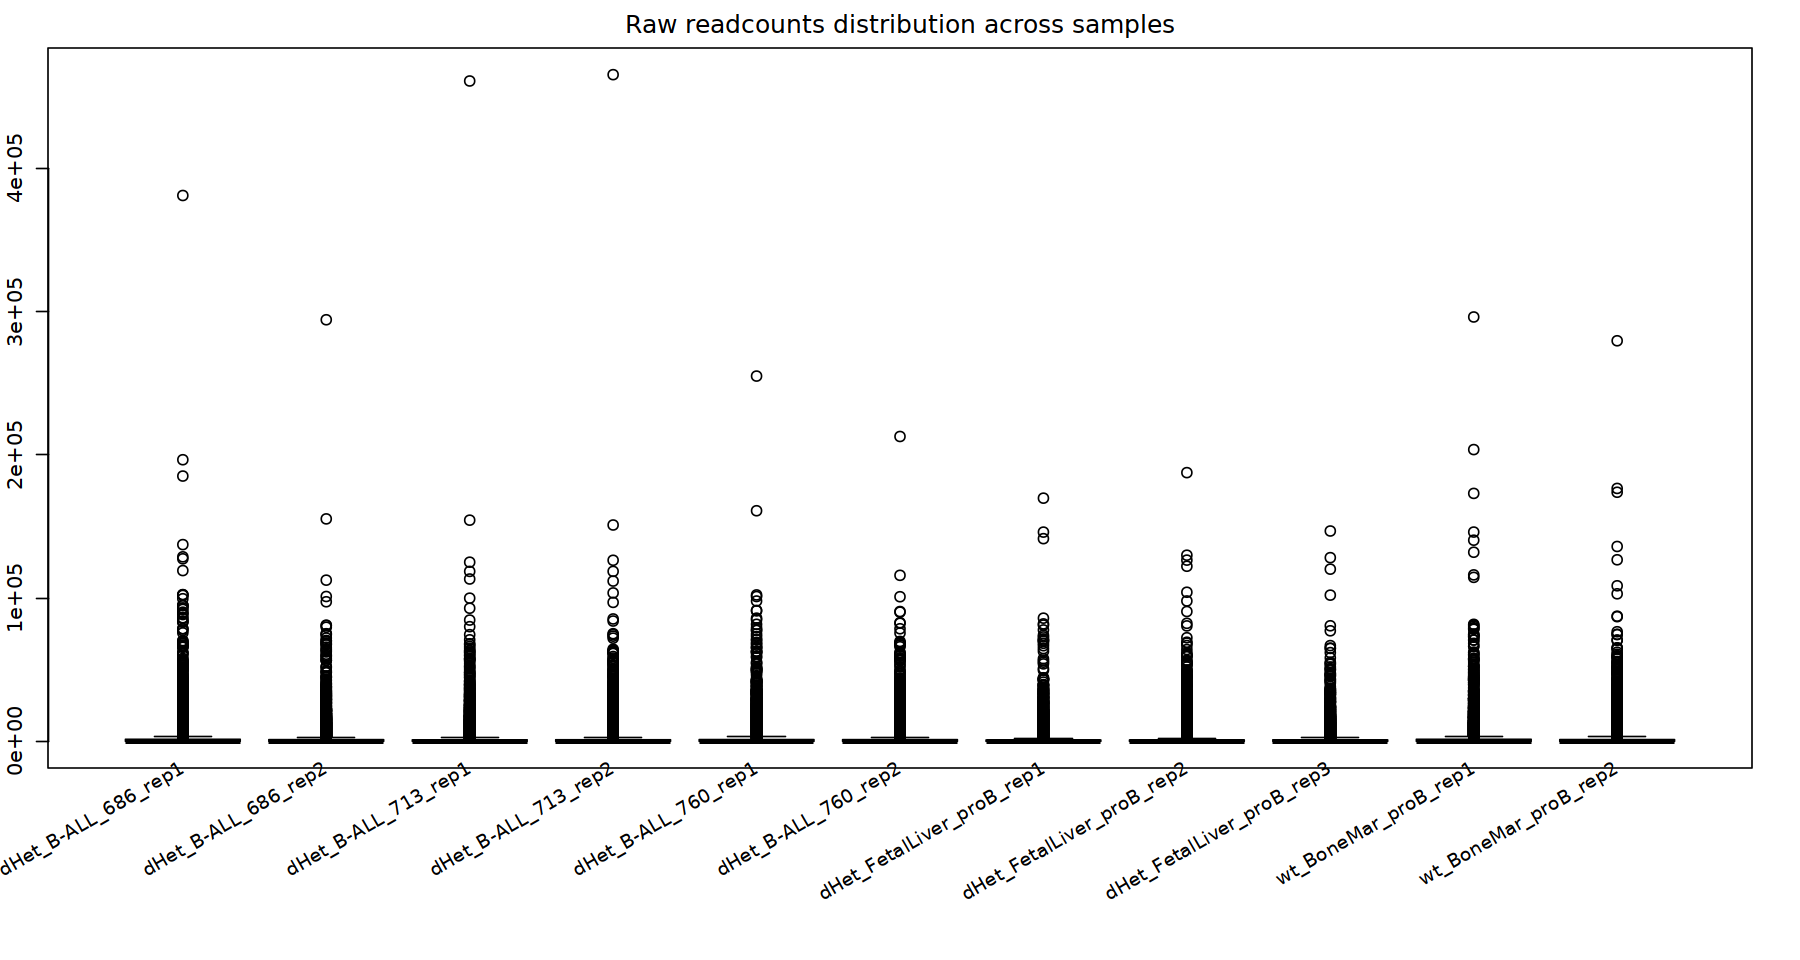

In [30]:
## Code cell 30 ##

opar <- par()
par(mar = c(8,2,2,2)) # to increase margin at the bottom to display full sample names
boxplot(counts[,-1], main = 'Raw readcounts distribution across samples', xaxt = "n") # no display of xlabels
text(1:11, y = par("usr")[3] - 0.45,
     labels = names(counts)[-1],
     srt = 30, adj = 1, xpd = NA, cex= 0.9)# add xlabels with 30 degres srotation
suppressWarnings(par(opar))


We can see that variance increases with the average level of expression by plotting standard deviation vs mean expression:

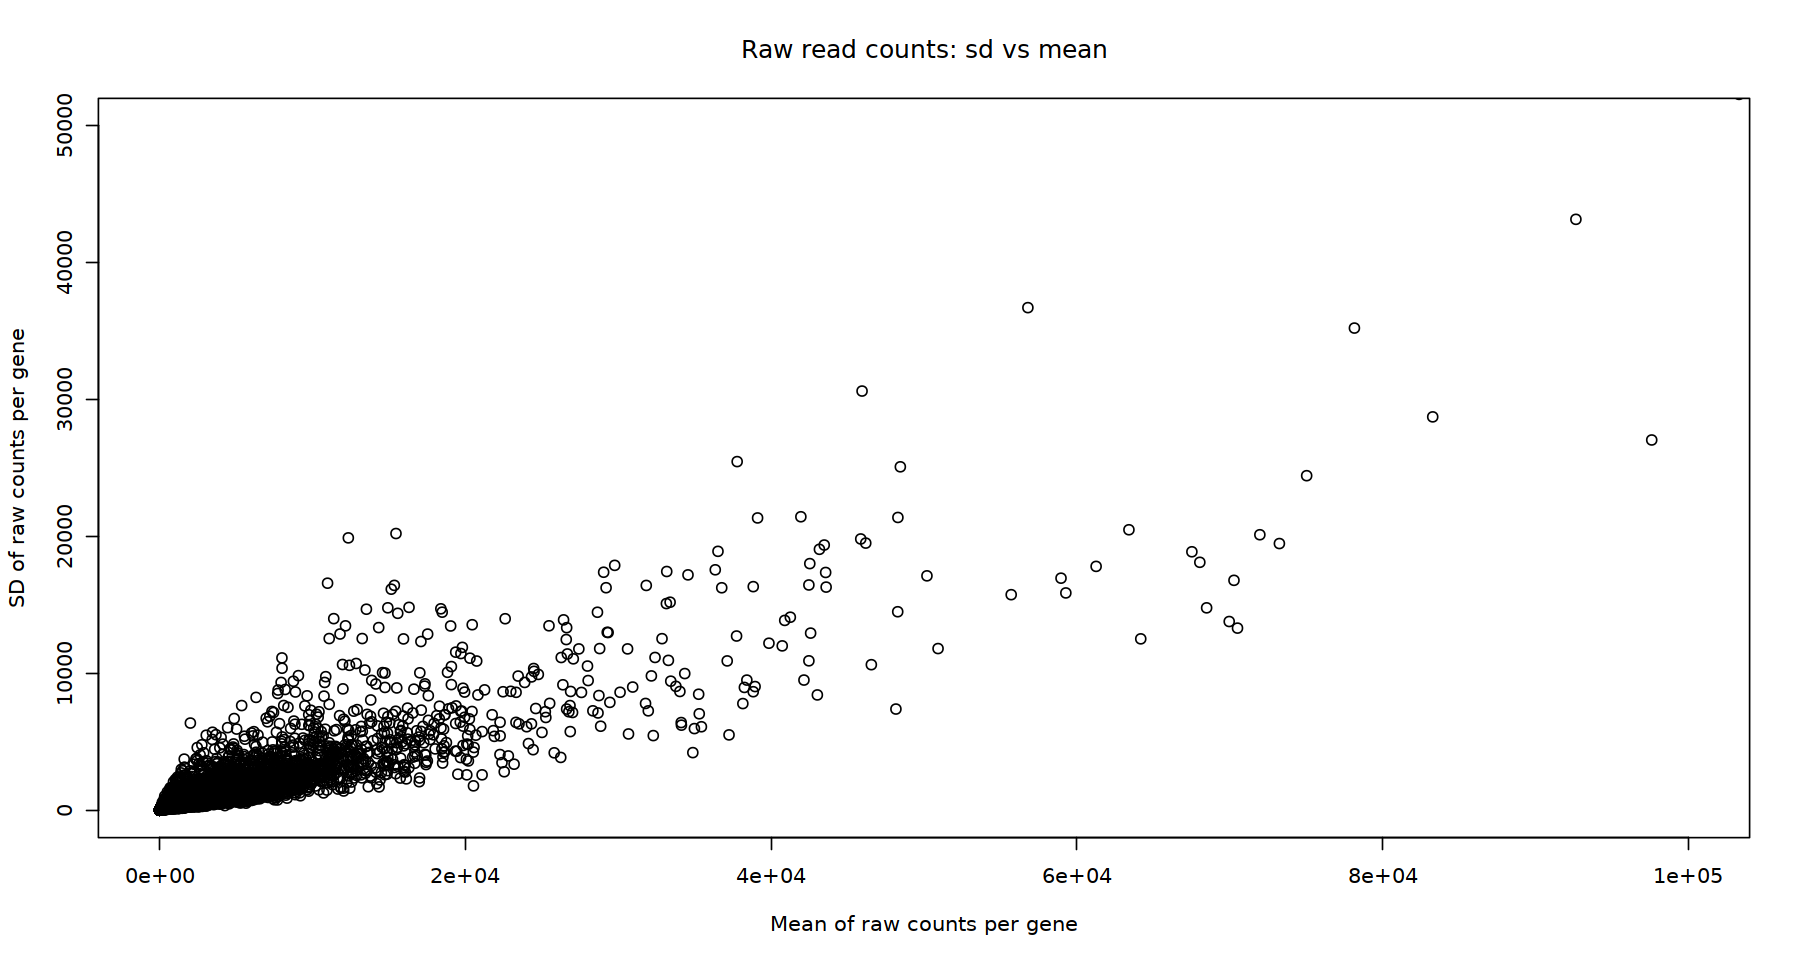

In [31]:
## Code cell 31 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(counts[,-1]), apply(counts[,2:12], 1, sd, na.rm = TRUE), 
     main = 'Raw read counts: sd vs mean', 
     xlim = c(0,100000), # to zoom
     ylim = c(0,50000), # to zoom
     xlab = "Mean of raw counts per gene",
     ylab = "SD of raw counts per gene"
    )


### 3.2 -  Data transformation and visualization
---

To avoid problems posed by raw counts, they can be transformed. **Several transformation methods exist to limit the dependence of variance on mean gene expression** among which :

    - Simple log2 transformation
    - VST : variance stabilizing transformation
    - rlog : regularized log transformation

For the moment, we are going to use only the first one to perform this first exploratory analysis on non-normalised data.   
The two other types of transformation are available in the DESeq2 package, that we will used in the next jupyter notebook.  
 

#### **-> log2 transformation**

This is one of the most used transformation in transcriptomics, as it helps to normalize the data (with the meaning of changing the data distribution to one closer to the normal distribution), and it enables a better visualization of low counts.   
    
Because some genes are not expressed (detected) in some samples, their counts are 0. As log2(0) equals -Inf, we add an offset, usually of 1, to every count value to create **pseudocounts**. The lowest value then is 1, or 0 on the log2 scale (log2(1) = 0).

In [32]:
## Code cell 32 ##

summary(log2(counts[,2]+1)) # summary for first sample column 2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.585   6.150   6.523  10.488  18.539 

In [33]:
## Code cell 33 ##

summary(log2(counts[,2:12]+1)) # summary for each sample

 dHet_B-ALL_686_rep1 dHet_B-ALL_686_rep2 dHet_B-ALL_713_rep1
 Min.   : 0.000      Min.   : 0.000      Min.   : 0.000     
 1st Qu.: 2.585      1st Qu.: 2.322      1st Qu.: 2.322     
 Median : 6.150      Median : 5.931      Median : 5.672     
 Mean   : 6.523      Mean   : 6.266      Mean   : 6.097     
 3rd Qu.:10.488      3rd Qu.:10.199      3rd Qu.: 9.999     
 Max.   :18.539      Max.   :18.167      Max.   :18.814     
 dHet_B-ALL_713_rep2 dHet_B-ALL_760_rep1 dHet_B-ALL_760_rep2
 Min.   : 0.000      Min.   : 0.00       Min.   : 0.000     
 1st Qu.: 2.322      1st Qu.: 2.00       1st Qu.: 2.000     
 Median : 5.833      Median : 5.70       Median : 5.807     
 Mean   : 6.219      Mean   : 6.09       Mean   : 6.164     
 3rd Qu.:10.098      3rd Qu.:10.26       3rd Qu.:10.206     
 Max.   :18.828      Max.   :17.96       Max.   :17.699     
 dHet_FetalLiver_proB_rep1 dHet_FetalLiver_proB_rep2 dHet_FetalLiver_proB_rep3
 Min.   : 0.000            Min.   : 0.000            Min.   : 0.000

We will check the distribution of read pseudocounts using a boxplot and add some colour to see if there is any difference between sample groups.

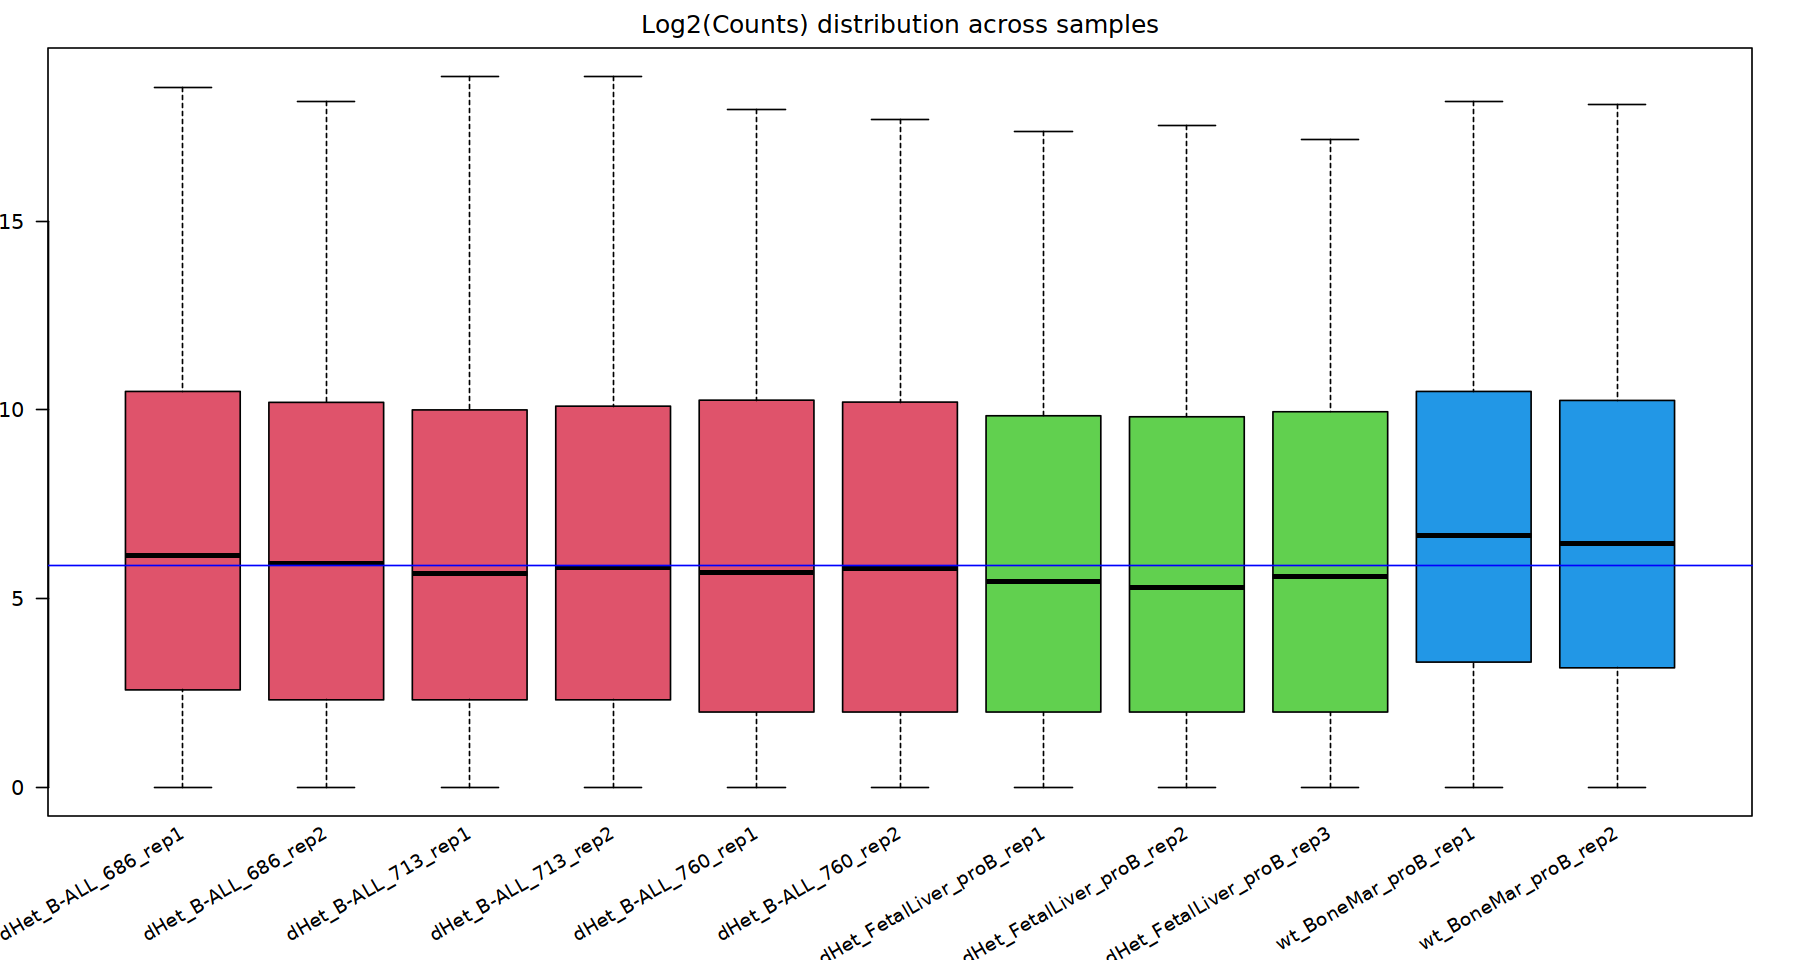

In [34]:
## Code cell 34 ##

# make a colour vector
conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
opar <- par()
par(mar = c(6,2,2,2))
boxplot(log2(counts[,2:12]+1),
        xlab = "", xaxt = "n",
        ylab = "Log2(Counts)",
        las = 2,
        col = conditionColor,
        main = "Log2(Counts) distribution across samples")
text(1:11, y = par("usr")[3] - 0.45,
     labels = names(counts)[-1],
     srt = 30, adj = 1, xpd = NA, cex= 0.9)


# Let's add a blue horizontal line that corresponds to the median
abline(h = median.default(as.matrix(log2(counts[,2:12]+1))), col="blue")

suppressWarnings(par(opar))

From the boxplot, we see that overall the density distributions of raw log-counts are not identical but still not very different from one sample to another.   
If a sample is really far above or below the blue horizontal line (overall median) we may need to investigate that sample further.

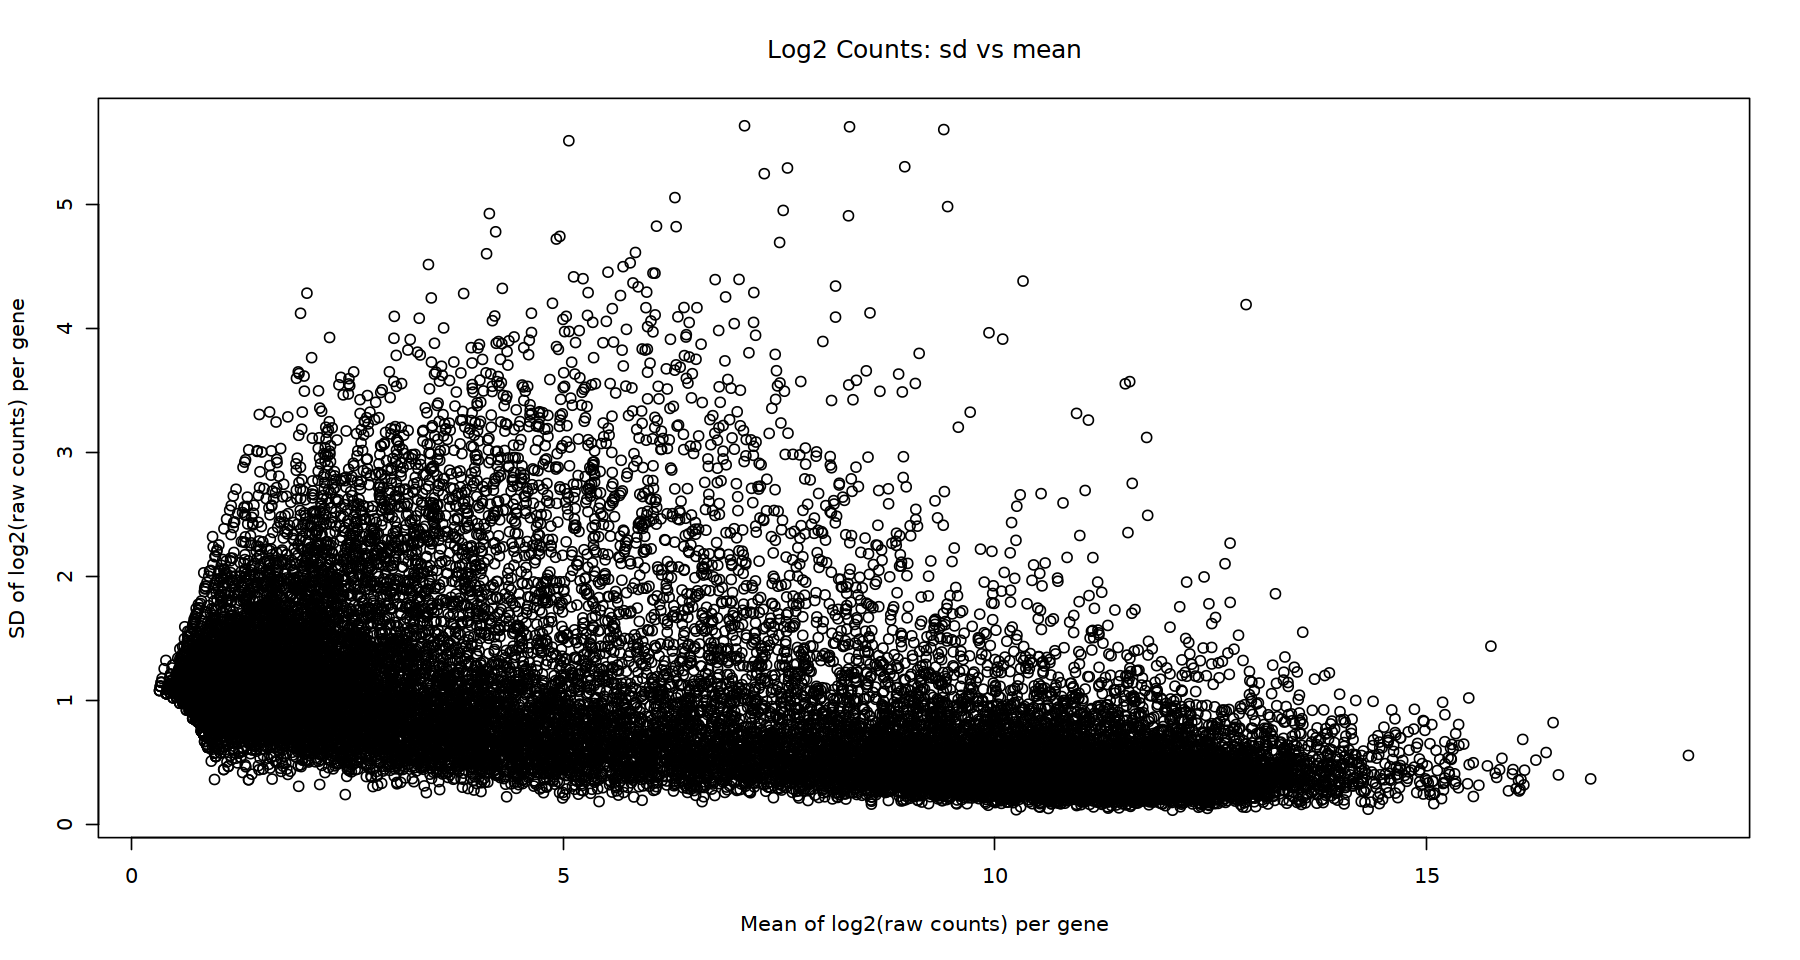

In [35]:
## Code cell 35 ##

# Log2 counts standard deviation (sd) vs mean expression

plot(rowMeans(log2(counts[,2:12]+1)),
              matrixStats::rowSds(as.matrix(log2(counts[,2:12]+1), na.rm = TRUE)), 
     main = 'Log2 Counts: sd vs mean',
     xlab = "Mean of log2(raw counts) per gene",
     ylab = "SD of log2(raw counts) per gene"
    
    )

In contrast to raw counts, with log2 transformed counts, lowly expressed genes (mean expression around 5 or below) show higher variation than highly expressed genes (mean expression above 10-12).

### 3.3 - Principal Component Analysis (PCA)
---

A principal component analysis (PCA) is an unsupervised method used to explore the data variance structure **by reducing its dimensions to a few principal components (PC) that explain the greatest variation in the data**.  PCA is an example of an unsupervised analysis, where we don’t specify the grouping of the samples *(see lecture 10)*.  
If the experiment is well controlled and has worked well, we should find that replicate samples cluster closely, whilst the greatest sources of variation in the data should be between treatments/sample groups.   
It is also an incredibly useful tool for checking for outliers and batch effects.

To run the PCA on non-normalized data, we will use the log2 transformation only. 

- transposition of data : 

In PCA, the variables are genes, and should thus be in columns. So in the code below, the `t()` function is used to transpose the dataframe: the result is a new dataframe with samples as rows and genes as columns.

In [36]:
## Code cell 36 ##

tlogcounts <- t(log2(counts[,2:12]+1))
dim(tlogcounts)

[1]    11 22927

- plot PCA:

To plot the PCA results we will use here the `autoplot` function from the `ggfortify` package (Tang, Horikoshi, and Li 2016). `ggfortify` is built on top of `ggplot2` and is able to recognise common statistical objects such as PCA results or linear models and it automatically generates summary plot of the results in an appropriate manner.

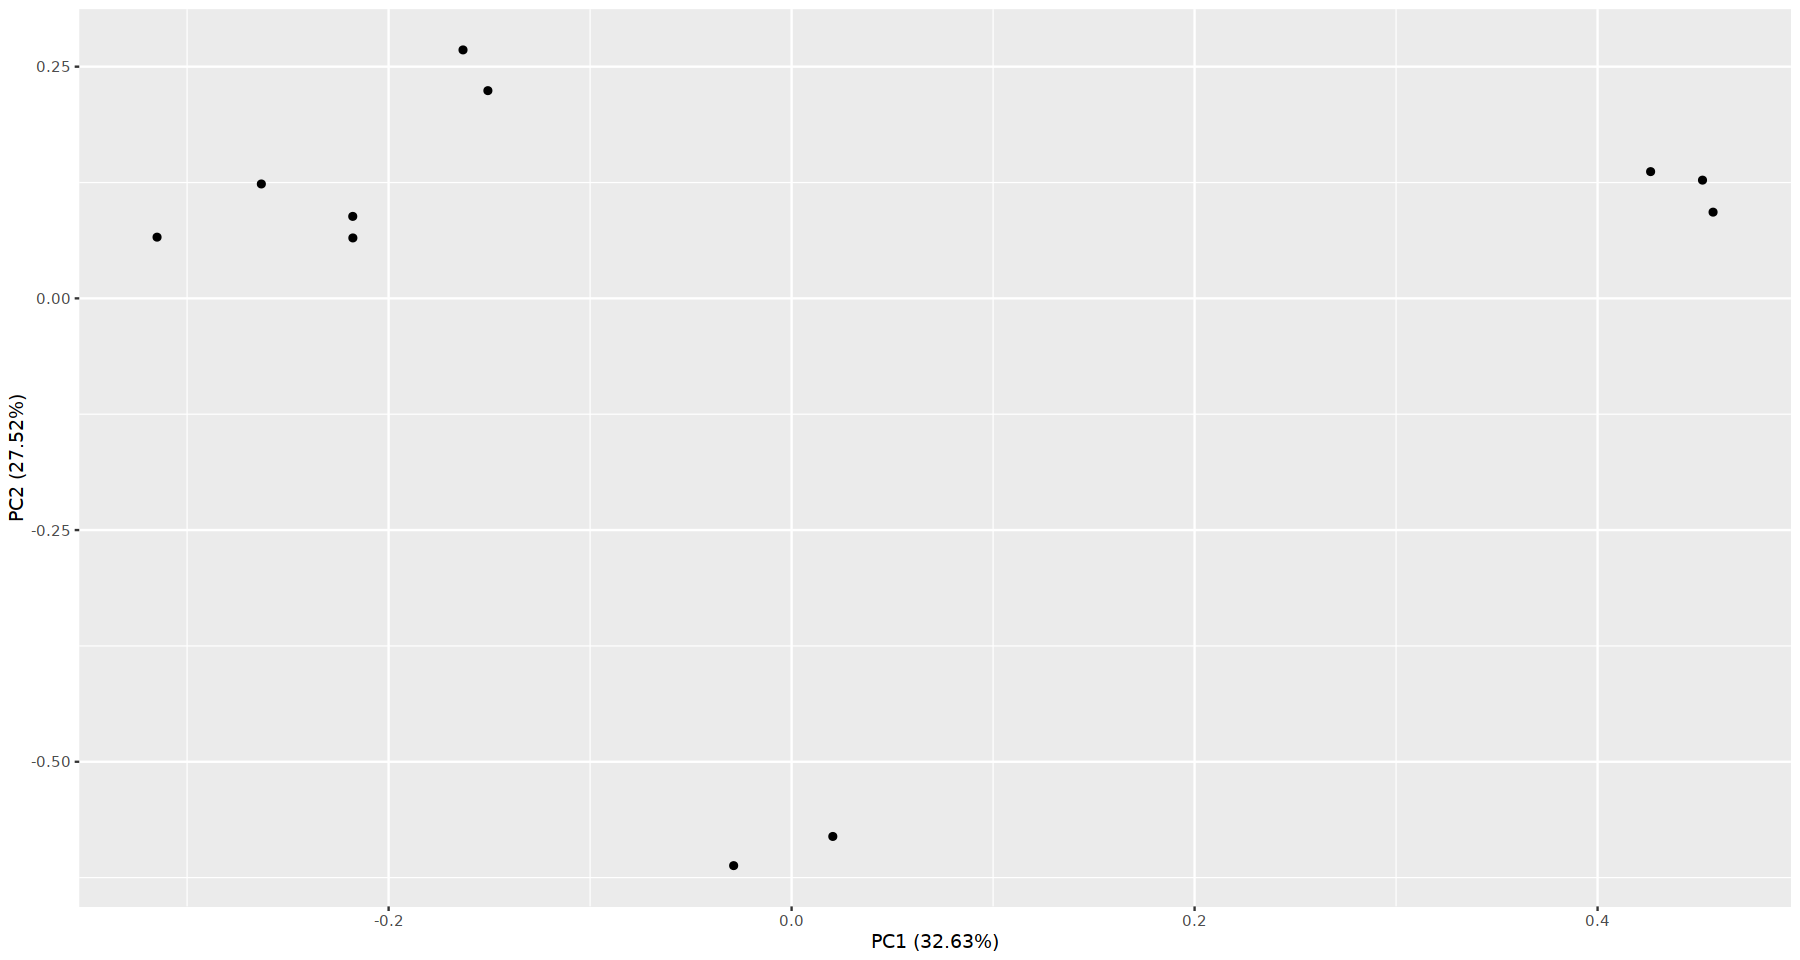

In [37]:
## Code cell 37 ##

# run PCA
PCAdata <- prcomp(tlogcounts)

# plot PCA
autoplot(PCAdata)

Without the names of the samples, or colours indicating their group, we cannot see if they cluster correctly.    

- add labels to PCA plot:

So we add colours and labels to the PCA plot.   
The package `ggrepel` allows us to add text to the plot, but ensures that points that are close together don’t have their labels overlapping (they repel each other).

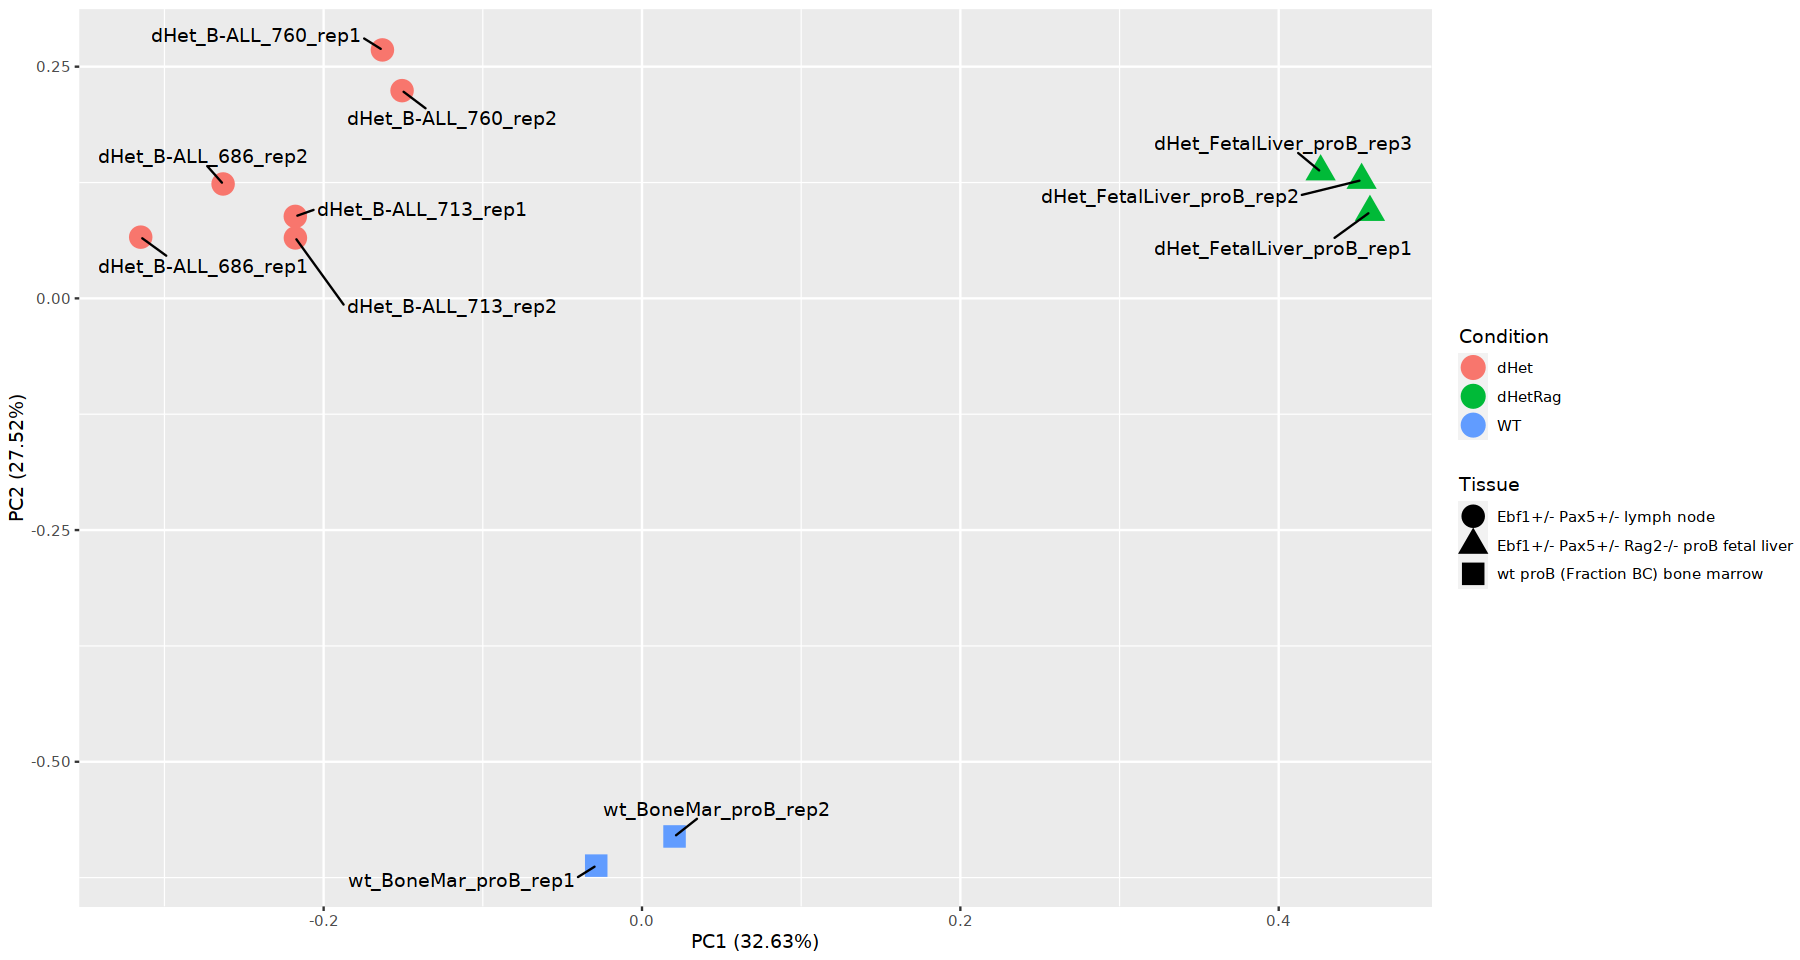

In [38]:
## Code cell 38 ##

autoplot(PCAdata,
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
    geom_text_repel(aes(x = PC1, y = PC2, label = SampleName),
                        box.padding = 0.8)


We can see that the first Principal Component (explaining the largest source of variation) shows in this dataset variation between samples from different conditions (the effect of interest), while the second PC (explaining the second largest source of variation) displays here sample differences due to WT vs mutant genotypes.   
It seems that there is no batch effect, but let's verify if none appears in the next PCs eigen vectors.  

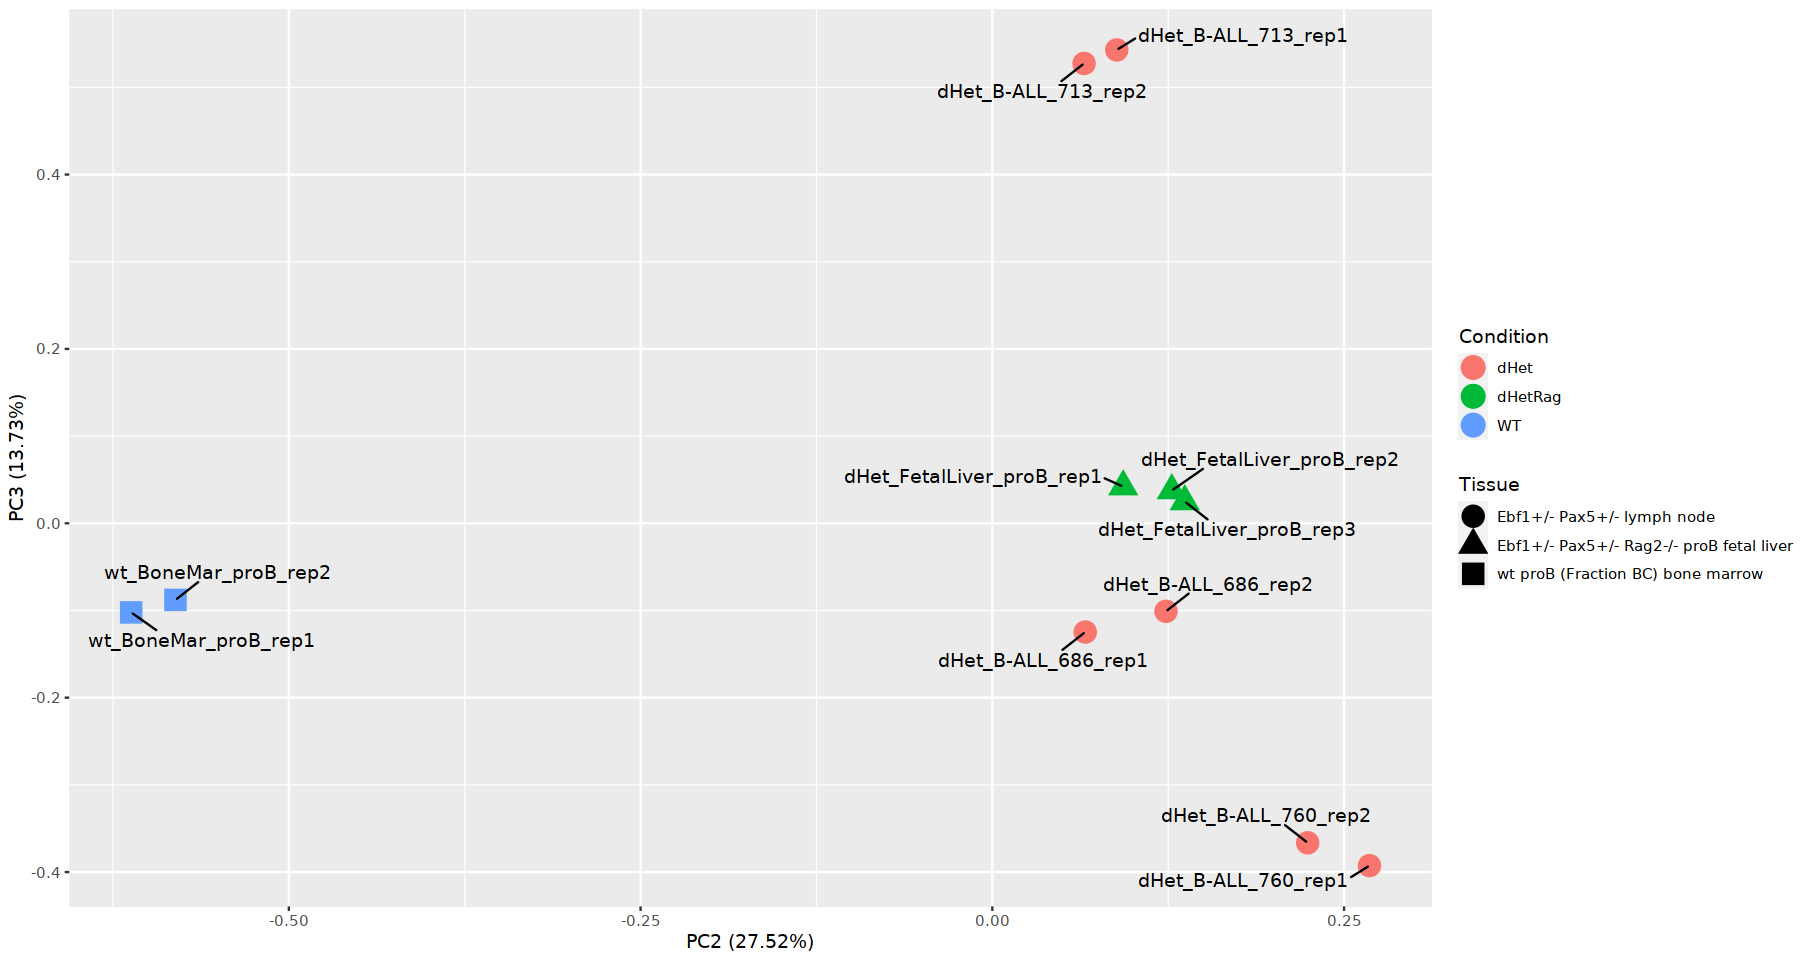

In [39]:
## Code cell 39 ##

autoplot(PCAdata,
         x = 2,    # PC2
         y = 3,    # PC3
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
    geom_text_repel(aes(x = PC2, y = PC3, label = SampleName),
                    box.padding = 0.8)


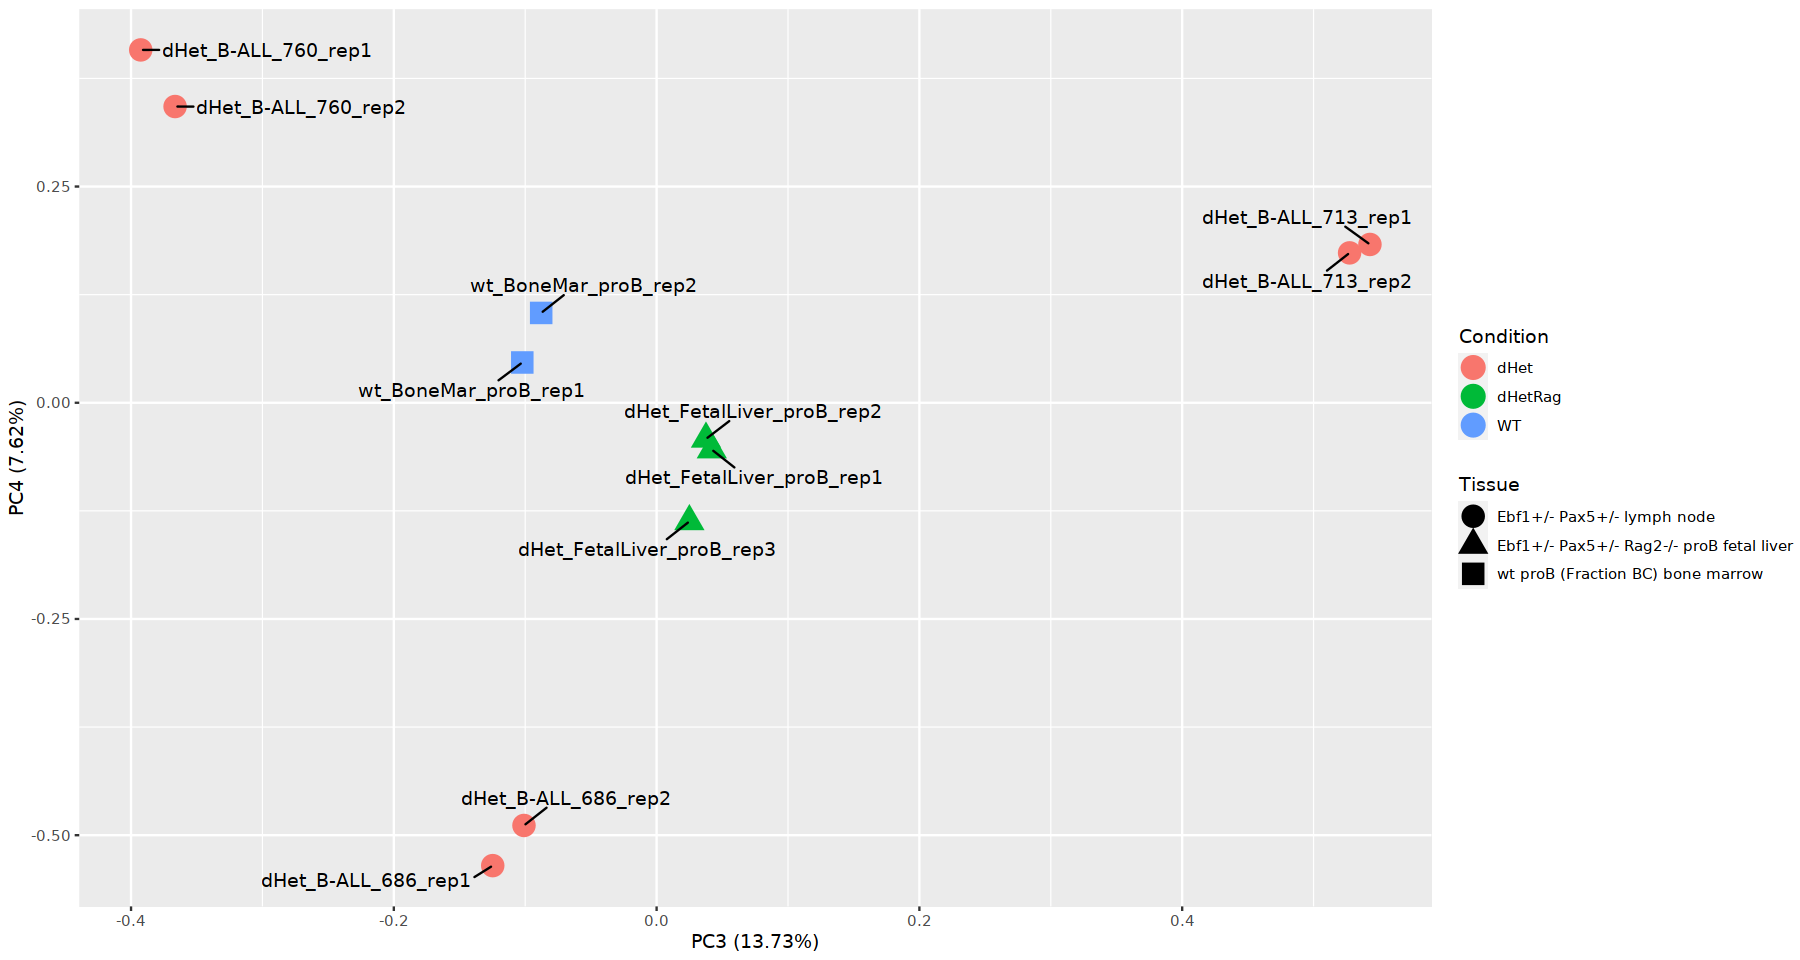

In [40]:
## Code cell 40 ##

autoplot(PCAdata,
         x = 3,    # PC3
         y = 4,    # PC4
         data = samples, 
         colour = "Condition", 
         shape = "Tissue",
         size = 6) +
    geom_text_repel(aes(x = PC3, y = PC4, label = SampleName),
                    box.padding = 0.8)

rm(PCAdata) # we remove the PCA dtaa from the session for memory reasons

On the basis of these last two plots, we cannot see a clear effect of a given factor to the variation depicted in PC3 and PC4, except maybe the difference between mice.

*Note: We will do a more detailed PCA after normalisation of the data in notebook P10.*

### 3.4 - Hierarchical clustering
---

This  representation can also be used to cluster the samples based on dissimilarity indexes *(see lecture 12, here we will use Ward distance)*. More information can be found with `?hclust` (or in the Contextual Help panel on the right, that can be opened via the Help menu).

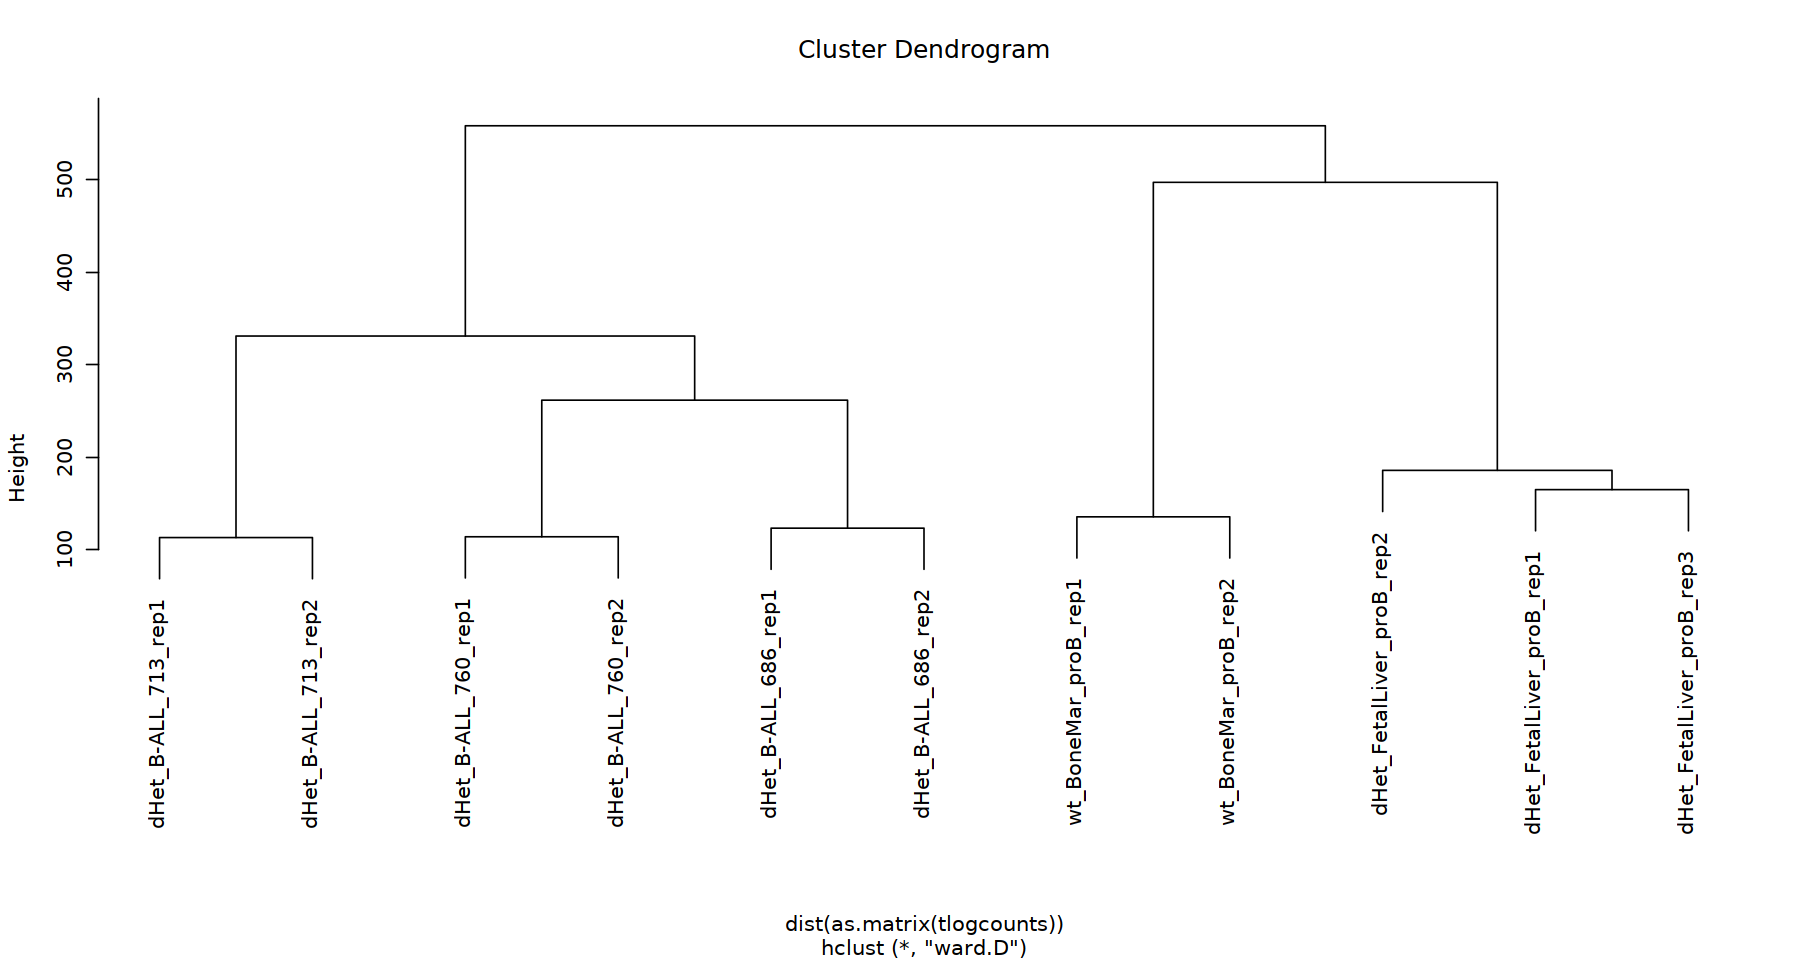

In [41]:
## Code cell 41 ##

clusters <- hclust(dist(as.matrix(tlogcounts)), method ="ward.D")
plot(clusters, labels = samples$SampleName)

rm(clusters, tlogcounts)    

We can see that our samples are grouped correctly, and that replicates from the same mouse cluster together, as expected.

### 3.5 - Density plot
---

A Density Plot can be used to visualize the distribution of data over a continuous interval. In RNA-seq analysis, this could be used to detect the presence or absence of batch effects in the data. Batch effects may be introduced through different experimental platforms, laboratory conditions, different sources of samples, different technicians, etc, and may introduce spurious variability which is not due to the condition under study (cancerous state of B and pro-B cells).   
This [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4636836/) comprehensively discusses batch effects and how they can be corrected.

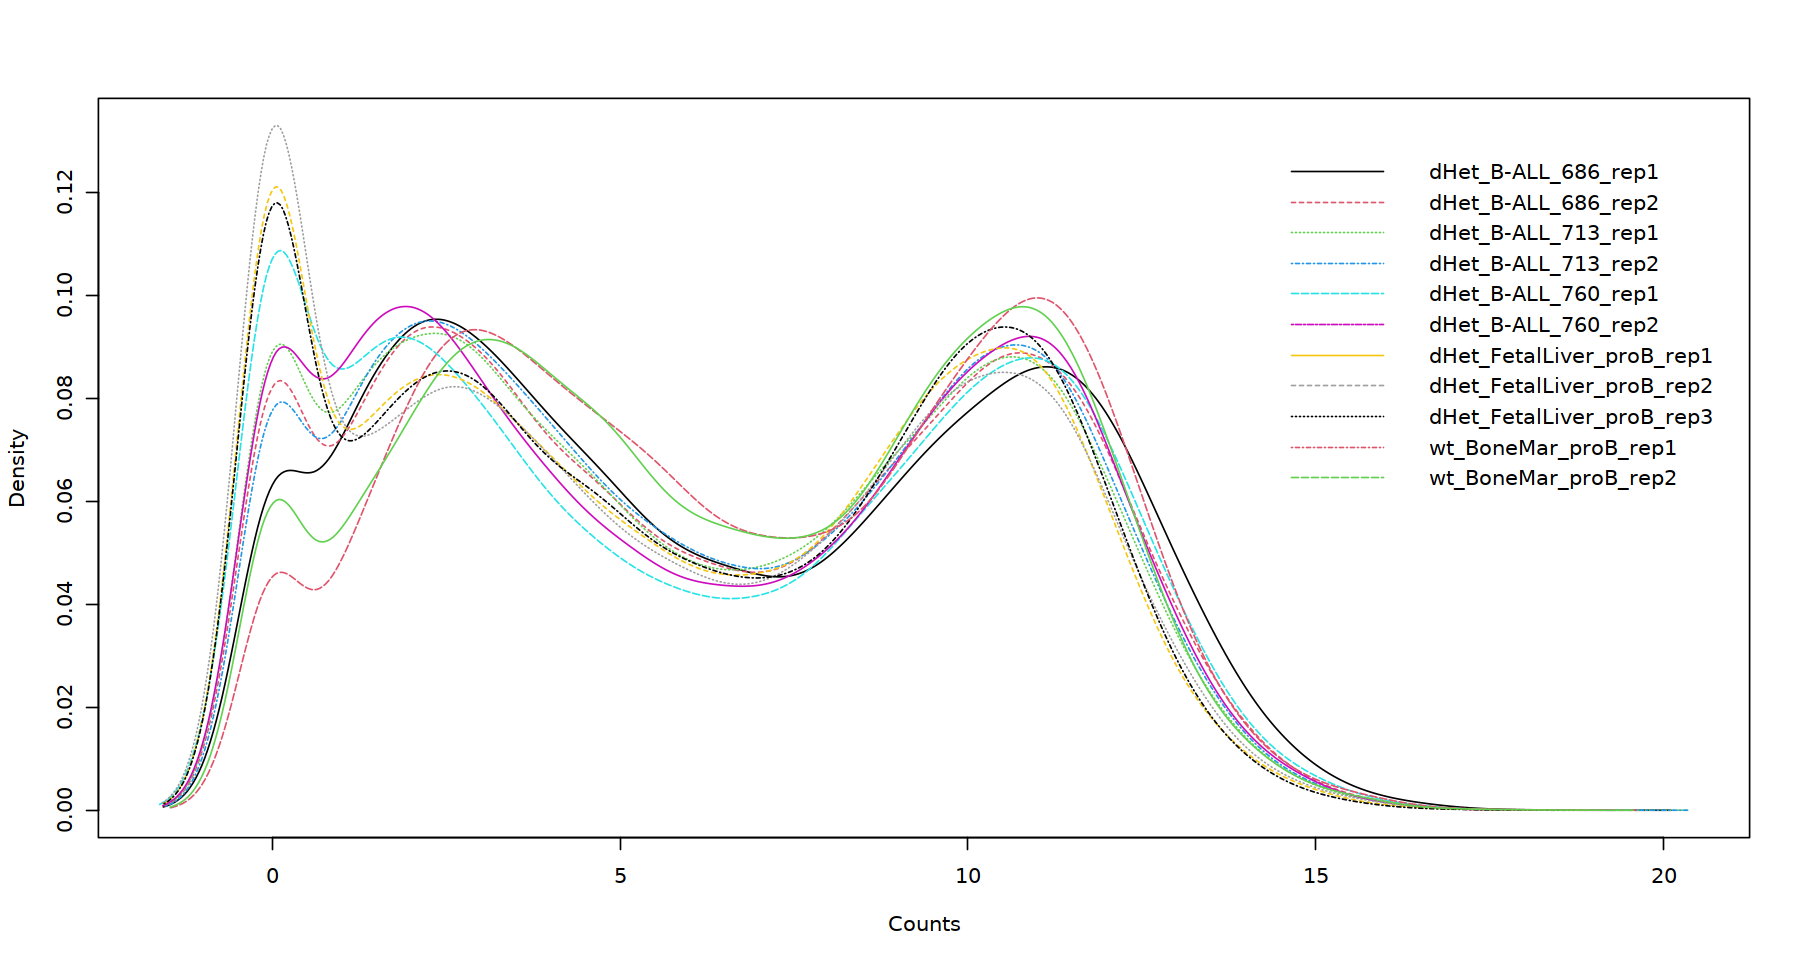

In [42]:
## Code cell 42 ##

affy::plotDensity(log2(counts[,2:12]+1),
                  xlab("Density"),ylab("Counts"),
                  col = 1:11)
legend(x = 14, y = 0.13,legend = names(log2(counts[,2:12]+1)),
       col = 1:11, lty = 1:11, bty = "n")

The density plots overlap for all samples, none stand out as having a different profile.   
This confirms that no batch effect is visible in our data that would need to be correted before going on with normalisation.   

To see examples of batch effects, you can have a look [there](https://evayiwenwang.github.io/Managing_batch_effects/detect.html). 

## 3 - Saving our results

We can save all the R objects created in this session in a single R object.   
This will help us to reload our dataframes without having to run the same commands.   

In [43]:
## Code cell 43 ##  

ls()
save(counts, samples, conditionColor, file = paste0("RawCounts_Samples.RData"))

[1] "conditionColor"     "counts"             "datafolder"        
[4] "gohome"             "myfolder"           "opar"              
[7] "pca1folder"         "samples"            "session_parameters"

---
___

Now we go on with the normalisation of read counts and differential expression analysis using `DESeq2`.  
  
**=> Step 9: DESeq2 Normalisation and Differential Expression analysis** 

The jupyter notebook used for the next session will be *Pipe_09-R403-DESeq2-normalisation-DE.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [44]:
## Code cell 44 ##   

myfolder
file.copy("/shared/projects/2312_rnaseq_cea/pipeline/Pipe_09-R403-DESeq2-normalisation-DE.ipynb",
          myfolder)



[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

[1] FALSE



**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks` folder. **Adjust the name with yours** and reformat as code cell to run it.

---

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a exploratory analysis of RNAseq expression data in R.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Claire Vandiedonck - 2021-2023   
Sandrine Caburet - 05/2023   
MAJ : 05/06/2023 by @CVandiedonck